# SUSI sweRun
This script runs Susi* for one or more than one sites in Sweden.
It tryes to facilitate a form to get the parameters, collects the smhi weather data and storage the outputs in a centralized folder per site.

Follow the link to susi ....
get the general instructions from ...

Alejandro G.
 /// I have to improve the description ///

In [ ]:
# Importing general libraries

import numpy as np
import pandas as pd
from datetime import datetime
import configparser
import argparse
import matplotlib.pylab as plt
import seaborn as sns
import sys
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.misc import derivative
from scipy.interpolate import InterpolatedUnivariateSpline as interS
from scipy.sparse import  diags
from scipy.sparse.linalg import  spsolve
#----------------------------------------------------------------------------
# Install non-standard packages
# !pip install xlsxwriter
# !pip install xlrd==1.2.0
# !pip install pyproj
# #--------------------------
# !pip install netCDF4
# !pip install datetime
# !pip install xlrd --upgrade
# !pip install dataframe_image
# # --------------------------
from pyproj import CRS, Transformer


In [ ]:
# Repositories 
if not os.path.exists('susi_2022'): 
    !git clone https://github.com/annamarilauren/susi_2022
else: print("Susi repository is already in yor computer")

if not os.path.exists('susi_SMHI'): 
    !git clone https://github.com/alejandrogandara/susi_SMHI
else: print("SMHI collect repository is already in yor computer")

In [1]:
# Importing Local libraries

import scripts.param_import as ipft # script to import from xls to dict

newpathsusi = 'susi_2022'
if newpathsusi not in sys.path: sys.path.insert(0,newpathsusi)
# -----------------------------------------------------------------------------
from susi.susi_utils import read_FMI_weather
from susi.susi_main import Susi
from inputs.susi_para import get_susi_para
from susi.susi_io import *

print (f"SUSI is ready to run!")

SUSI is ready to run!


### Functions

In [2]:
#getVariablesFromFile

from pandas import read_excel
import traceback
from datetime import datetime

#import operator
#import json
#from functools import reduce  # forward compatibility for Python 3
# p is the parameter file

#get variables
def getVariablesFromFile(file, site, var=False):
    # var [True, False]
    # file ['file path']
    vars = {}
    try: p = read_excel(file)
    except: 
        print('file does not exists')
        return
    if var:
        try: p=p[(p['commented'] != '#') & (p['path'].isna()) & (p['var'] == var)]
        except: 
            print('variable not found')
            return
    else: p=p[(p['commented'] != '#') & ((p['path'].isna()) | (p['var'] == 'wpara') )]
    p.reset_index()
    for ind in p.index:
        if p['type'][ind] == 'date': 
            
            date = datetime.strptime(p[site][ind], '%Y-%m-%d %H:%M:%S')
            globals()[p['var'][ind]] = date
            vars[p['var'][ind]] = date
            #datetime.datetime(date.year,date.month,date.day)
        else: 
            globals()[p['var'][ind]] = p[site][ind] 
            vars[p['var'][ind]] = p[site][ind]
        print('variable updated: ' + p['var'][ind]+' = '+ str(p[site][ind]))
    return vars


def getDicInFile(file, site, var=False):
    try: p = read_excel(file)
    except: 
        print('file does not exists')
        return
    #p = p.where(notnull(p), '')
    if var:
        try: p=p[(p['commented'] != '#') & (p['path'].notnull()) & (p['var'] == var)]
        except: 
            print('variable not found')
            return
    else: p=p[(p['commented'] != '#') & (p['path'].notnull())]
    p.reset_index()

    for uvar in p['var'].unique():
        sp = p[p['var'] == uvar]
        print('------------------------------')
        print('dictionary: '+ uvar + '  keys:' + str(len(sp)))
        globals()[uvar]
        for ind in sp.index:
            try: 
                path = p['path'][ind].replace(', ','][')
                if p['type'][ind] == 'str': 
                    value = "'"+ str(p[site][ind]) + "'"
                else: value = str(p[site][ind])
                #exec(p['var'][ind] + p['path'][ind].replace(',','][').replace(' ', '') + ' = ' + str(p[site][ind]))
                line = uvar + path + ' = ' + value
                print(line)
                exec(line)
            #except: print('ERROR: '+ uvar + path + ' = ' + value + ' NOT UPDATED' )
            except Exception: traceback.print_exc()

### Site selection

In [3]:
# Name convention
# weather file:     inputs/.../weather/  {site}_weather.csv
# motti file:       inputs/.../motti/    {site}_motti_lyr_0.xlsx
# You will define the input folder later

param_file = "inputs\sweden\parameters.xlsx"
sNames = read_excel(param_file).columns[9:]
print(pd.DataFrame(sNames))

# Define motti files, please follow the name convention or add it manually
data_files = {}
for s in sNames:
    key = s
    data_files[key] = {}
    data_files[key]['para'] = f'susi_para_{s}'
    data_files[key]['wFile'] = f'{s}_weather.csv'
    data_files[key]['motti_lyr_0'] = f'{s}_motti_input_lyr_0.xlsx'
    data_files[key]['motti_lyr_1'] = f'{s}_motti_input_lyr_0.xlsx'        # fake, just to fill the gap
    data_files[key]['motti_lyr_2'] = f'{s}_motti_input_lyr_0.xlsx'        # fake, just to fill the gap




               0
0      01_Bjdamm
1      03_Korpis
2    04_Fröjered
3     05_SträRed
4      06_Risabo
5     07_Rothult
6     08_Ydreham
7     09_Gröngöl
8   10_Hällehult
9      11_Ökalix
10     12_Ökalix
11     13_Ökalix
12    14_Höglund
13   15_Jörnmark


### Which site are you running?

In [4]:
siteID = 5
site = list(data_files.keys())[siteID]
site

'07_Rothult'

In [5]:
vparam = ipft.getVariablesFromFile(param_file, site)  # AG, gets the parameter from the frist worksheet in xlsx


variable updated: sarkaSim = 325
variable updated: start_date = 1984-01-01 00:00:00
variable updated: end_date = 2015-12-31 00:00:00


### 3.1 Default inputs

In [31]:
folderName= ipft.mkfolder('outputs/')                                        # output folder
inpath = 'inputs/sweden/weather/'
mottipath = 'inputs/sweden/motti/'                                            # folder where weather files are
mottifile = {'path':mottipath,
              'dominant':{1: data_files[site]['motti_lyr_0']},
              'subdominant':{0:data_files[site]['motti_lyr_1']},
              'under':{0:data_files[site]['motti_lyr_2']}}

graph_folder = ipft.mkfolder('outputs/graphs/')
wdata = data_files[site]['wFile']
# -------------------------------- UNTIL HERE
# imports variables from table
vparam = ipft.getVariablesFromFile(param_file, site)  # AG, gets the parameter from the frist worksheet in xlsx
#sarkaSim = vparam['sarkaSim']
start_date = vparam['start_date']
end_date = vparam['end_date']

sarkaSim = 40.                                                                  # strip width, ie distance between ditches, m
#start_date = datetime(2011,1,1)
#end_date = datetime(2021,12,31)
#sarkaSim = start_date = end_date = None




start_yr = start_date.year 
end_yr = end_date.year
yrs = (end_date - start_date).days/365.25
n = int(sarkaSim / 2)                                                           # number of computation nodes in the strip

ageSim = {'dominant': 45.*np.ones(n),
          'subdominant': 0*np.ones(n),
          'under': 0*np.ones(n)}                                                         # age of the stand in each node

sfc =  np.ones(n, dtype=int)*3                                                            # site fertility class


#ageSim['dominant'][int(n/2):] = 2.
#ageSim[4:-4] = 2.

          
wpara, cpara, org_para, spara, outpara, photopara = get_susi_para(wlocation='undefined', peat='krycklan', 
                                                                          folderName=folderName, hdomSim=None,  
                                                                          ageSim=ageSim, sarkaSim=sarkaSim, sfc=sfc, susiPath = inpath,
                                                                          n=n)

forc=read_FMI_weather(0, start_date, end_date, sourcefile=inpath+wdata)           # read weather input

#spara['canopylayers']['dominant'][int(n/2):] = 2                                                                        
#spara['canopylayers']['subdominant'][:int(n/2)] = 1                                                                        


outputs/ already exists, ready to go
outputs/graphs/ already exists, ready to go
variable updated: sarkaSim = 325
variable updated: start_date = 1984-01-01 00:00:00
variable updated: end_date = 2015-12-31 00:00:00
 + Reading meteorological input file from 
    - inputs/sweden/weather/07_Rothult_weather.csv


In [32]:
vparam

{'sarkaSim': 325,
 'start_date': datetime.datetime(1984, 1, 1, 0, 0),
 'end_date': datetime.datetime(2015, 12, 31, 0, 0)}

## Importing parameters from table

In [25]:
# import parameter from './inputs/sweden/parameters.xlsx' book 
getDicInFile(param_file, site)

------------------------------
dictionary: wpara  keys:9
wpara['start_date'] = '1984-01-01 00:00:00'
wpara['end_date'] = '2015-12-31 00:00:00'
wpara['infolder'] = '/sweden/'
wpara['infile_d'] = '07-Rothult_weather.csv'
wpara['start_yr'] = 1984
wpara['end_yr'] = 2015
wpara['description'] = 'Sweden, 07-Rothult'
wpara['lat'] = 57.81666666666667
wpara['lon'] = 15.466666666666667
------------------------------
dictionary: spara  keys:15
spara['sitename'] = 'swe_site_07-Rothult'
spara['species'] = 'Spruce'
spara['hdom'] = 23.7
spara['vol'] = 395
spara['smc'] = 'Peatland'
spara['ditch depth west'] = [-0.6, -1.1]
spara['ditch depth east'] = [-0.6, -1.1]
spara['ditch depth 20y west'] = [-0.6, -1.1]
spara['ditch depth 20y east'] = [-0.6, -1.1]
spara['scenario name'] = ['Control', 'TEST']
spara['slope'] = 5.252344
spara['peat type'] = ['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']
spara['peat type bottom'] = ['S']
spara['vonP'] = True
spara['vonP bottom'] = 5
------------------------------
dictionary: 

In [ ]:
spara['ditch depth west'] 

In [ ]:
outpara['netcdf']

### 3.2 Adjust profile, stand, management or weather as you like

In [ ]:
spara

In [ ]:
wdata

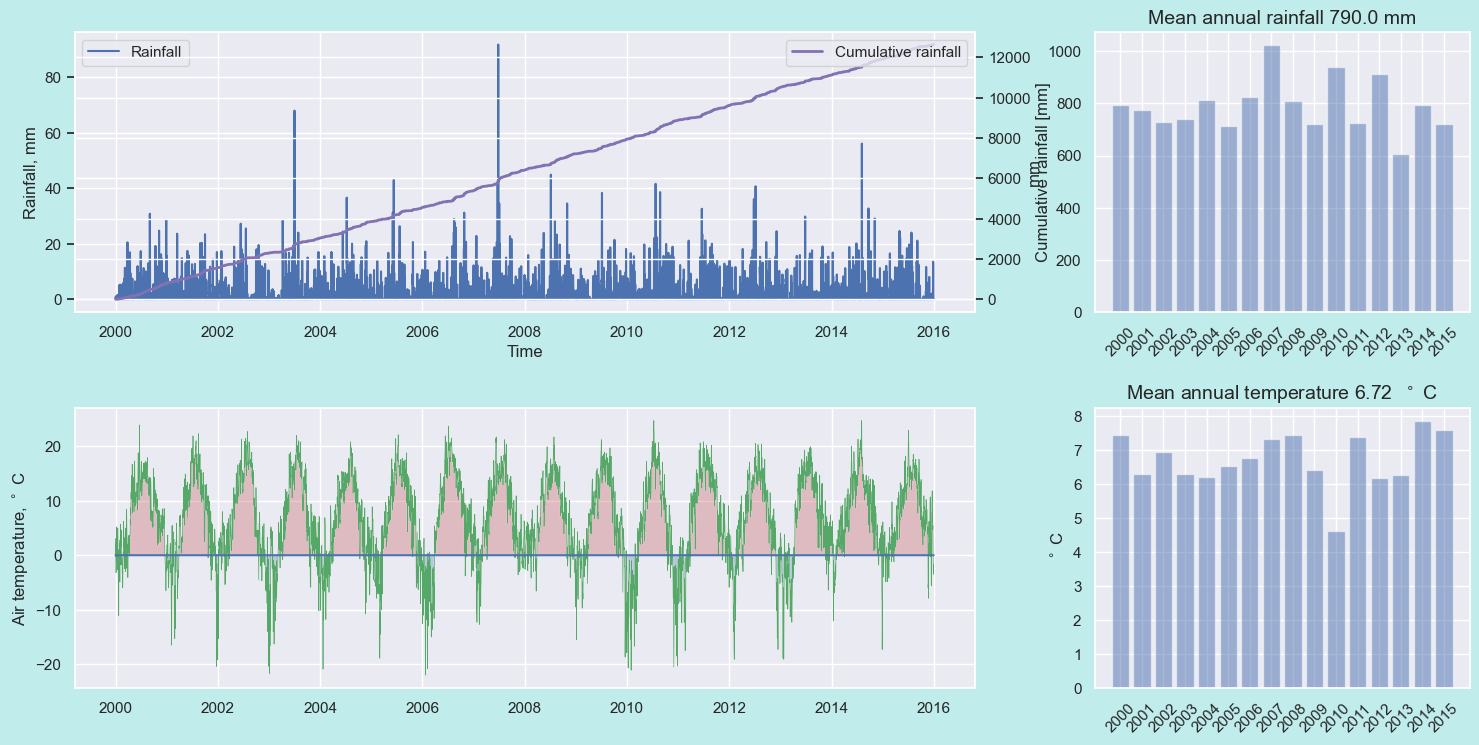

In [26]:
from susi.susi_io import *
graph_output = graph_folder + wdata[:-4] + '_weather_graph.png'
weather_fig(forc)        #Draw the weather input figure

### 3.4 Run the simulation

In [ ]:
# in case Susi() returns write permission error
#ncf.close()

In [9]:
susi = Susi()
 
susi.run_susi(forc, wpara, cpara, org_para, spara, outpara, photopara, start_yr, end_yr, wlocation = 'undefined', 
                                mottifile=mottifile, peat= 'krycklan', photosite='All data', 
                                folderName=folderName,ageSim=ageSim, sarkaSim=sarkaSim, sfc=sfc)

******** Susi-peatland simulator v.10 (2022) c Annamari Laurén *********************
           
Initializing stand and site:
**** creating Susi netCDF4 file: outputs/swe_site_07_Rothult_susi.nc ****
    + netCDF file created
      - Weather input: Sweden, 07-Rothult , start: 2011 , end: 2021
      - Latitude: 6409552 , Longitude: 528277
dominant initialized
subdominant initialized
under initialized
  + Site:
   + Number of columns: 20
    - Site fertility class:
     [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
  + Stand:
    - age:
        dominant: [45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45.
 45. 45.] yrs
        subdominat: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] yrs
        under: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] yrs
  + Soil: 
    - peat top: S , von P: 2
    - peat bottom: S , von P: 5
  + Drainage:
    - Strip widht: 40.0 m
    - Ditch depth west: [-0.6, -1.1]
    - Ditch depth east: [-0.6, -1.1]
    -

o:\projects\forestProductivity\git\susi-swe\susi_2022\susi\allometry.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'][idx]=df['age'][idx]+5./365.


Canopy and moss layer hydrology initialized
Peat strip initialized
30 0.05
Peat temperature profile initialized
Soil hydrology, temperature and DOC models initialized
***********************************
Computing canopy and soil hydrology  4018  days scenario: Control
Resetting strip scenario
  - day # 0  hdom  12.62  m,  LAI  1.48  m2 m-2
  - day # 0 iterations 18


o:\projects\forestProductivity\git\susi-swe\susi_2022\susi\canopylayer.py:226: RuntimeWarning: invalid value encountered in divide
  self.NPP = self.NPP * nut_stat / self.stems  * 1.1                     # returned back to tree basis unit
o:\projects\forestProductivity\git\susi-swe\susi_2022\susi\canopylayer.py:227: RuntimeWarning: invalid value encountered in divide
  self.NPP_pot = self.NPP_pot * nut_stat / self.stems * 1.1               # returned back to tree basis units


  - day # 365  hdom  13.48  m,  LAI  1.58  m2 m-2
  - day # 365 iterations 14
  - day # 730  hdom  13.48  m,  LAI  1.58  m2 m-2
  - day # 730 iterations 14
  - day # 1095  hdom  14.13  m,  LAI  1.68  m2 m-2
  - day # 1095 iterations 11
  - day # 1460  hdom  14.75  m,  LAI  1.77  m2 m-2
  - day # 1460 iterations 7
  - day # 1825  hdom  15.46  m,  LAI  1.86  m2 m-2
  - day # 1825 iterations 6
  - day # 2190  hdom  16.14  m,  LAI  1.95  m2 m-2
  - day # 2190 iterations 5


C:\Users\aoga0001\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aoga0001\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
o:\projects\forestProductivity\git\susi-swe\susi_2022\susi\canopygrid.py:612: RuntimeWarning: divide by zero encountered in divide
  x = (s * AE + rho * cp * Ga * D) / (s + g * (1.0 + Ga / Gs))  # Wm-2


  - day # 2555  hdom  16.76  m,  LAI  2.01  m2 m-2
  - day # 2555 iterations 13
  - day # 2920  hdom  17.37  m,  LAI  2.07  m2 m-2
  - day # 2920 iterations 4
  - day # 3285  hdom  17.9  m,  LAI  2.11  m2 m-2
  - day # 3285 iterations 8
  - day # 3650  hdom  18.47  m,  LAI  2.15  m2 m-2
  - day # 3650 iterations 8
  - day # 4015  hdom  19.04  m,  LAI  2.18  m2 m-2
  - day # 4015 iterations 5
***********************************
Computing canopy and soil hydrology  4018  days scenario: TEST
Resetting strip scenario
  - day # 0  hdom  12.62  m,  LAI  1.48  m2 m-2
  - day # 0 iterations 19
  - day # 365  hdom  13.48  m,  LAI  1.58  m2 m-2
  - day # 365 iterations 12
  - day # 730  hdom  13.48  m,  LAI  1.58  m2 m-2
  - day # 730 iterations 18
  - day # 1095  hdom  14.16  m,  LAI  1.69  m2 m-2
  - day # 1095 iterations 7
  - day # 1460  hdom  14.81  m,  LAI  1.78  m2 m-2
  - day # 1460 iterations 5
  - day # 1825  hdom  15.56  m,  LAI  1.88  m2 m-2
  - day # 1825 iterations 5
  - day # 2190

## Draw figures

C:\Users\aoga0001\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


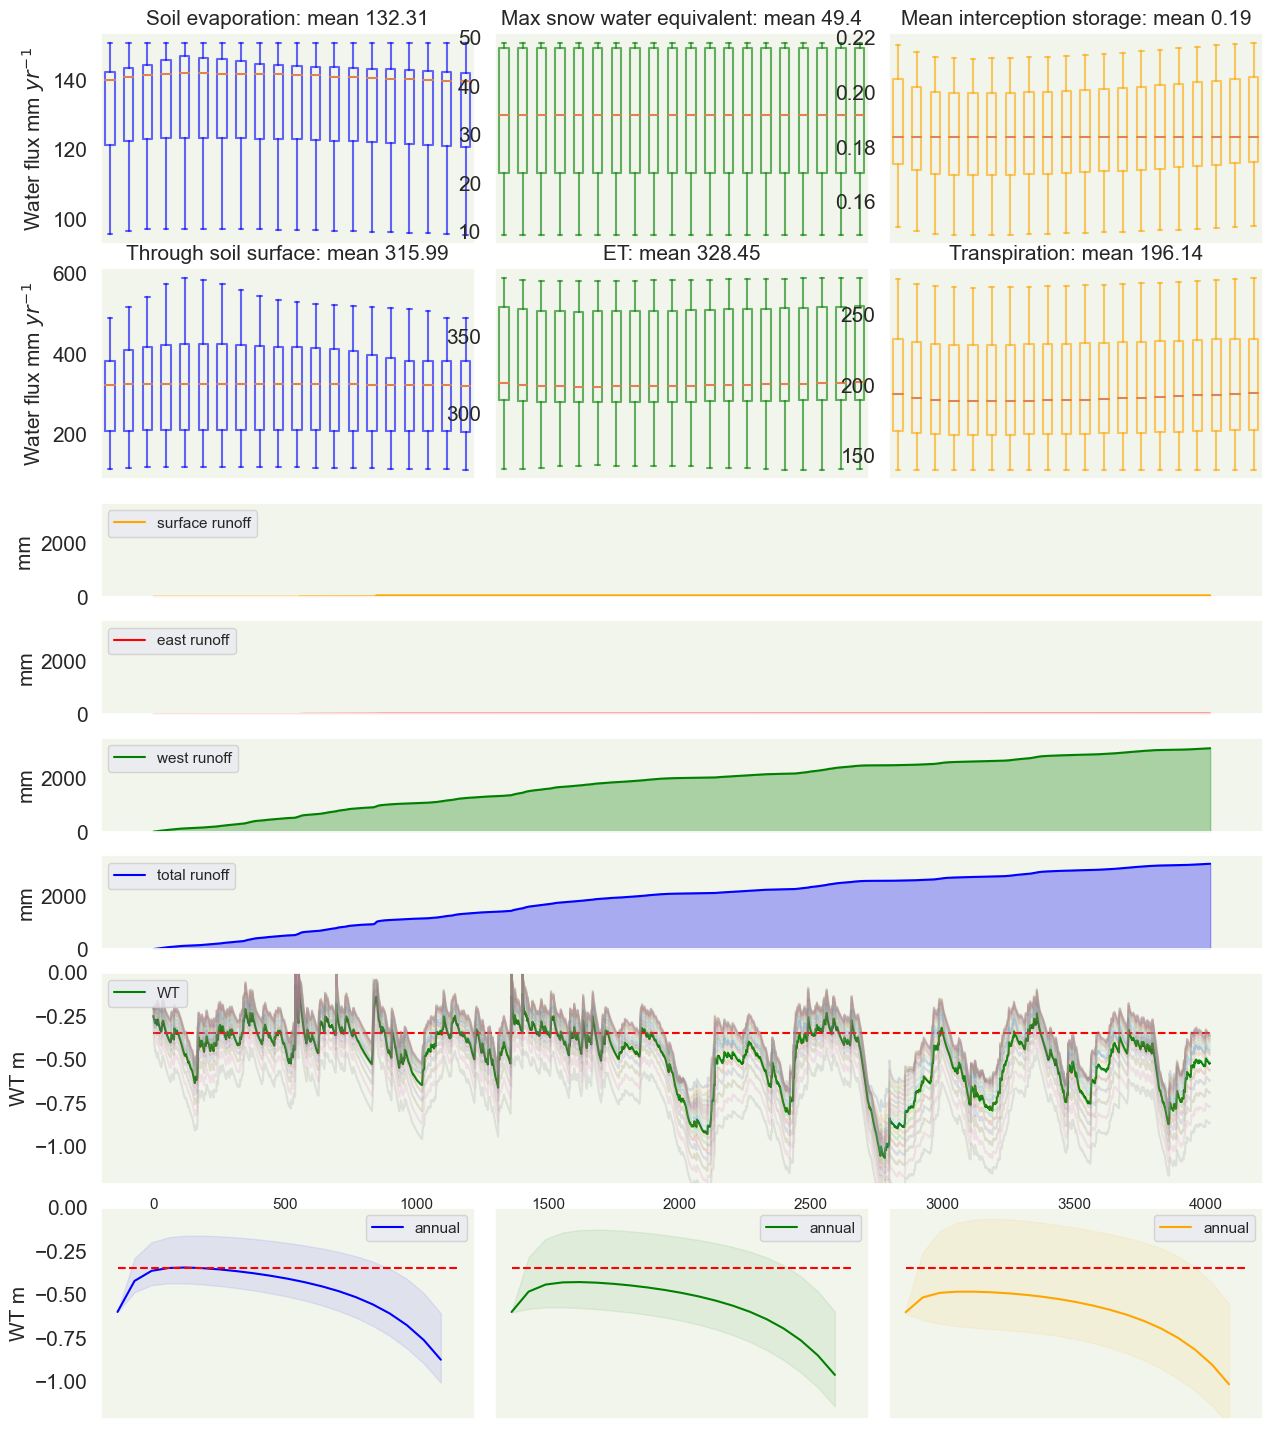

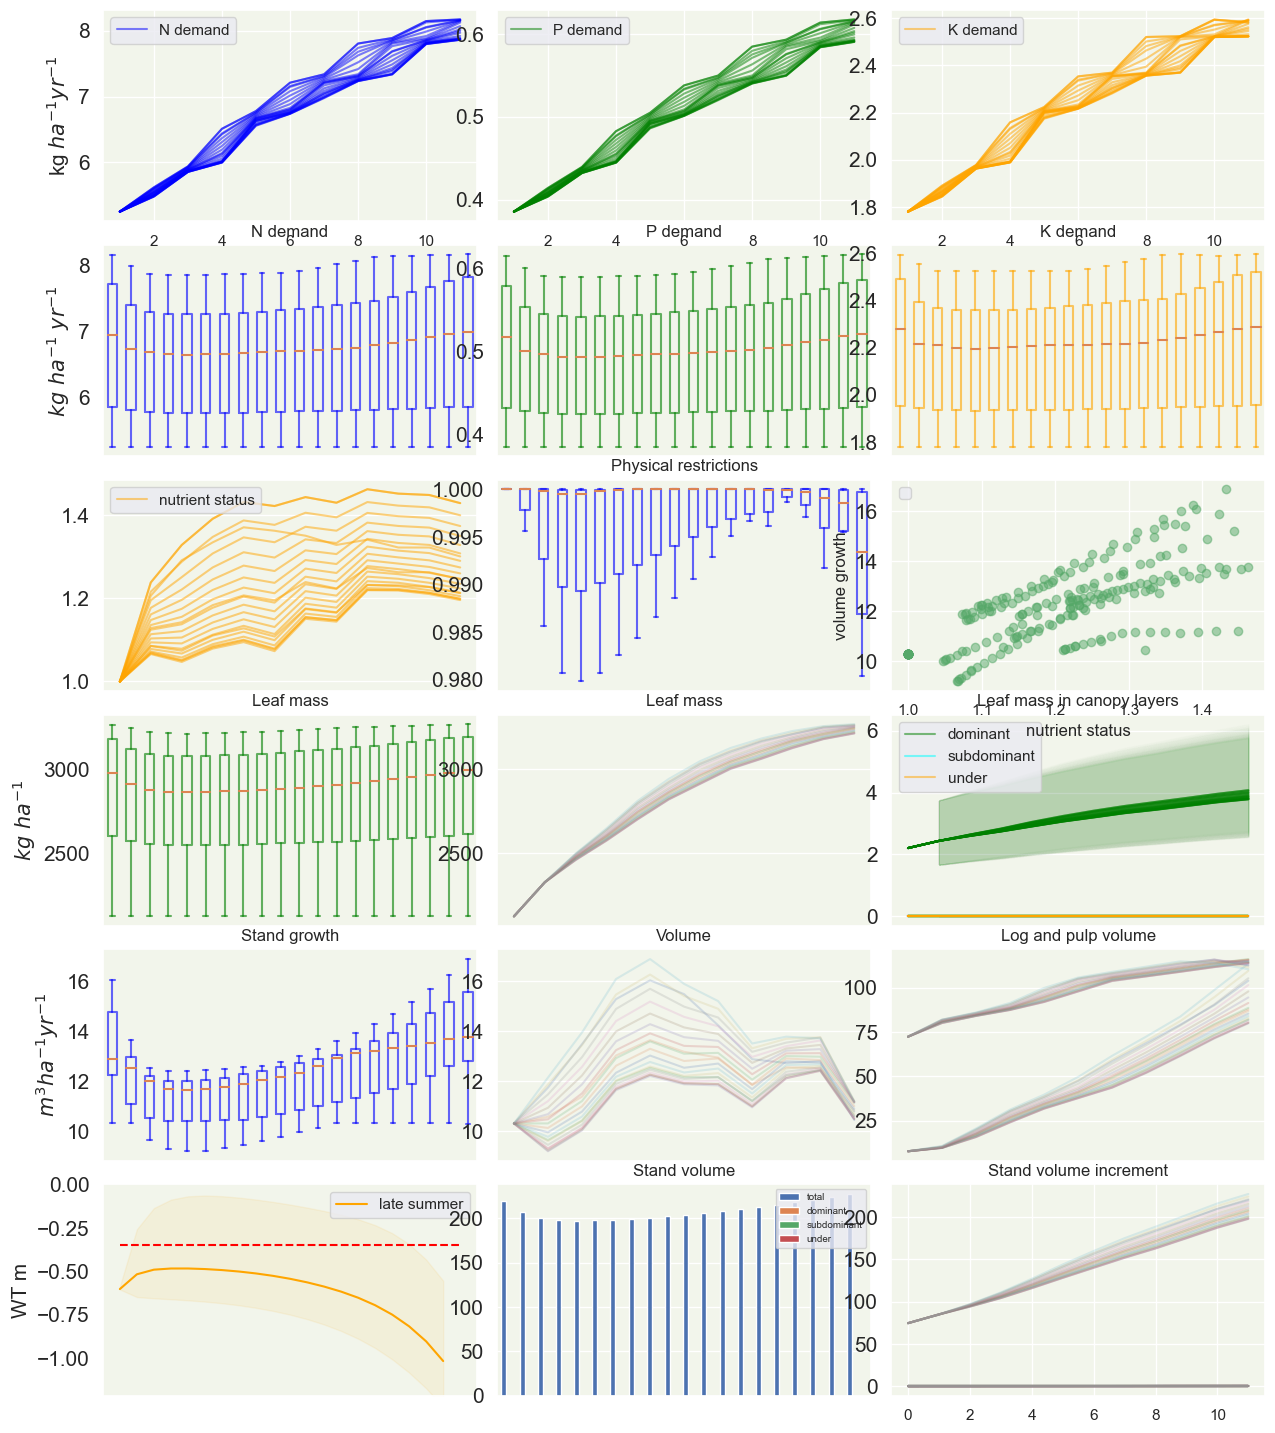

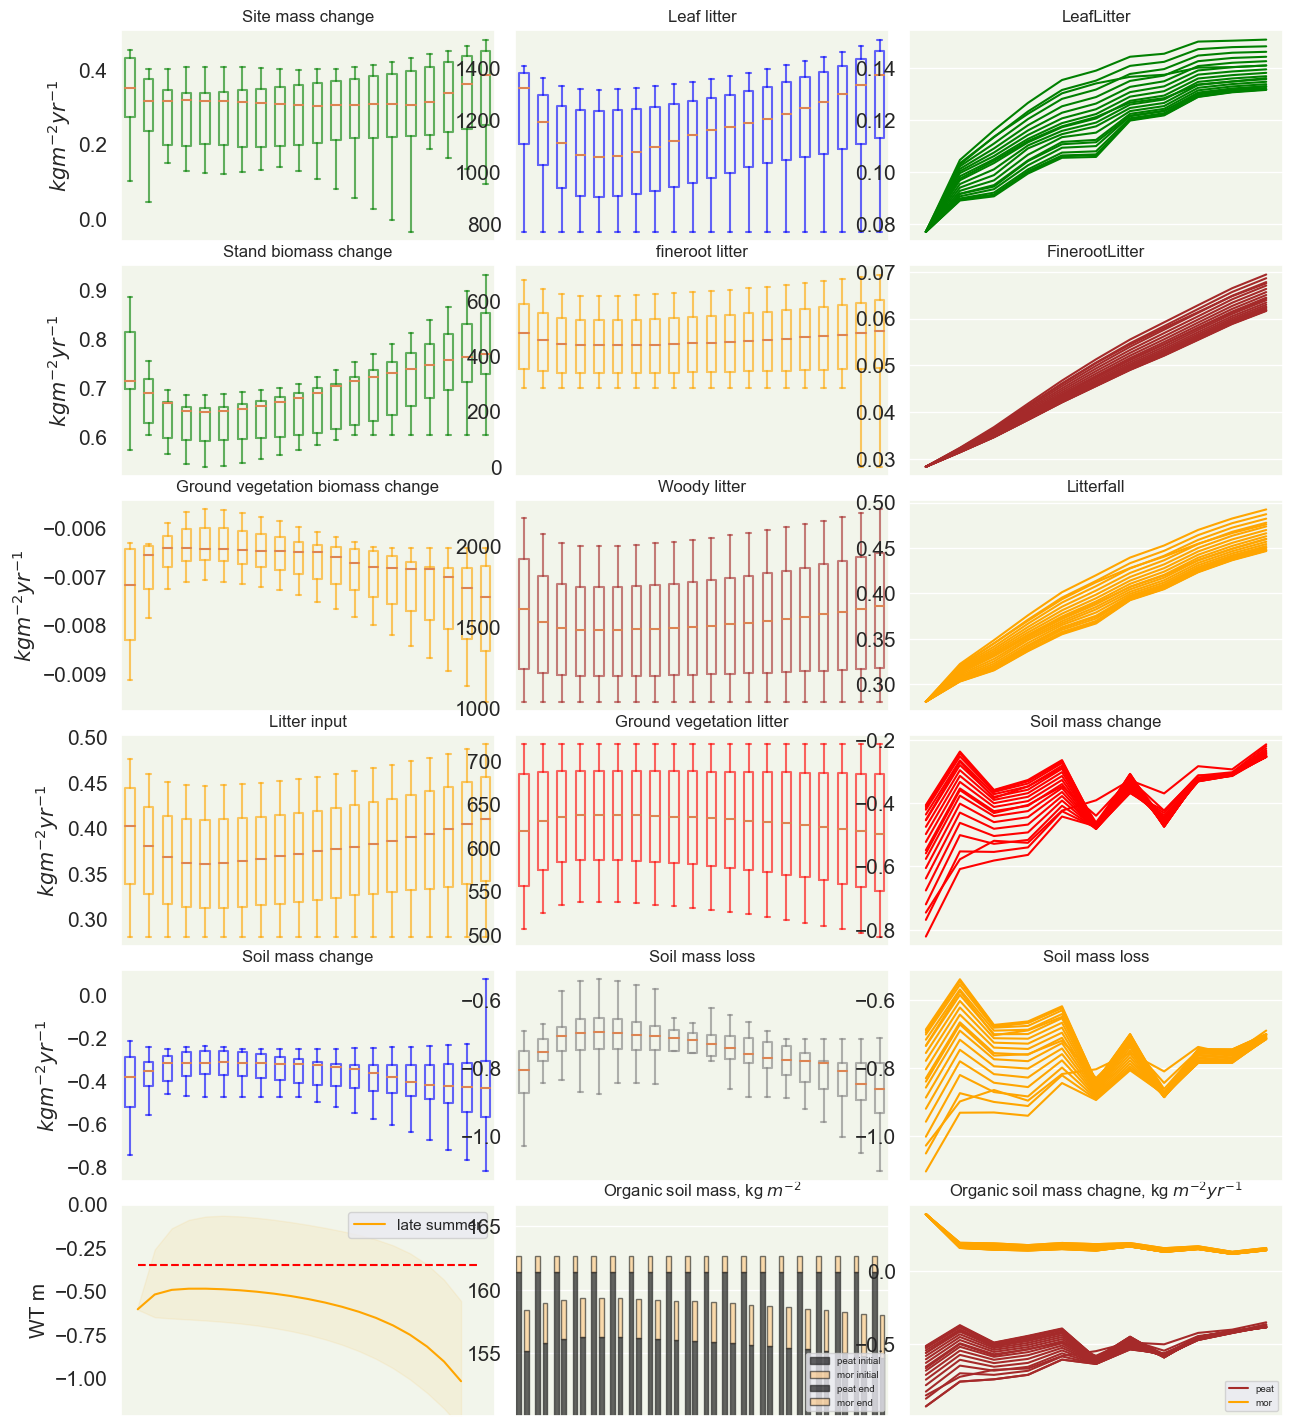

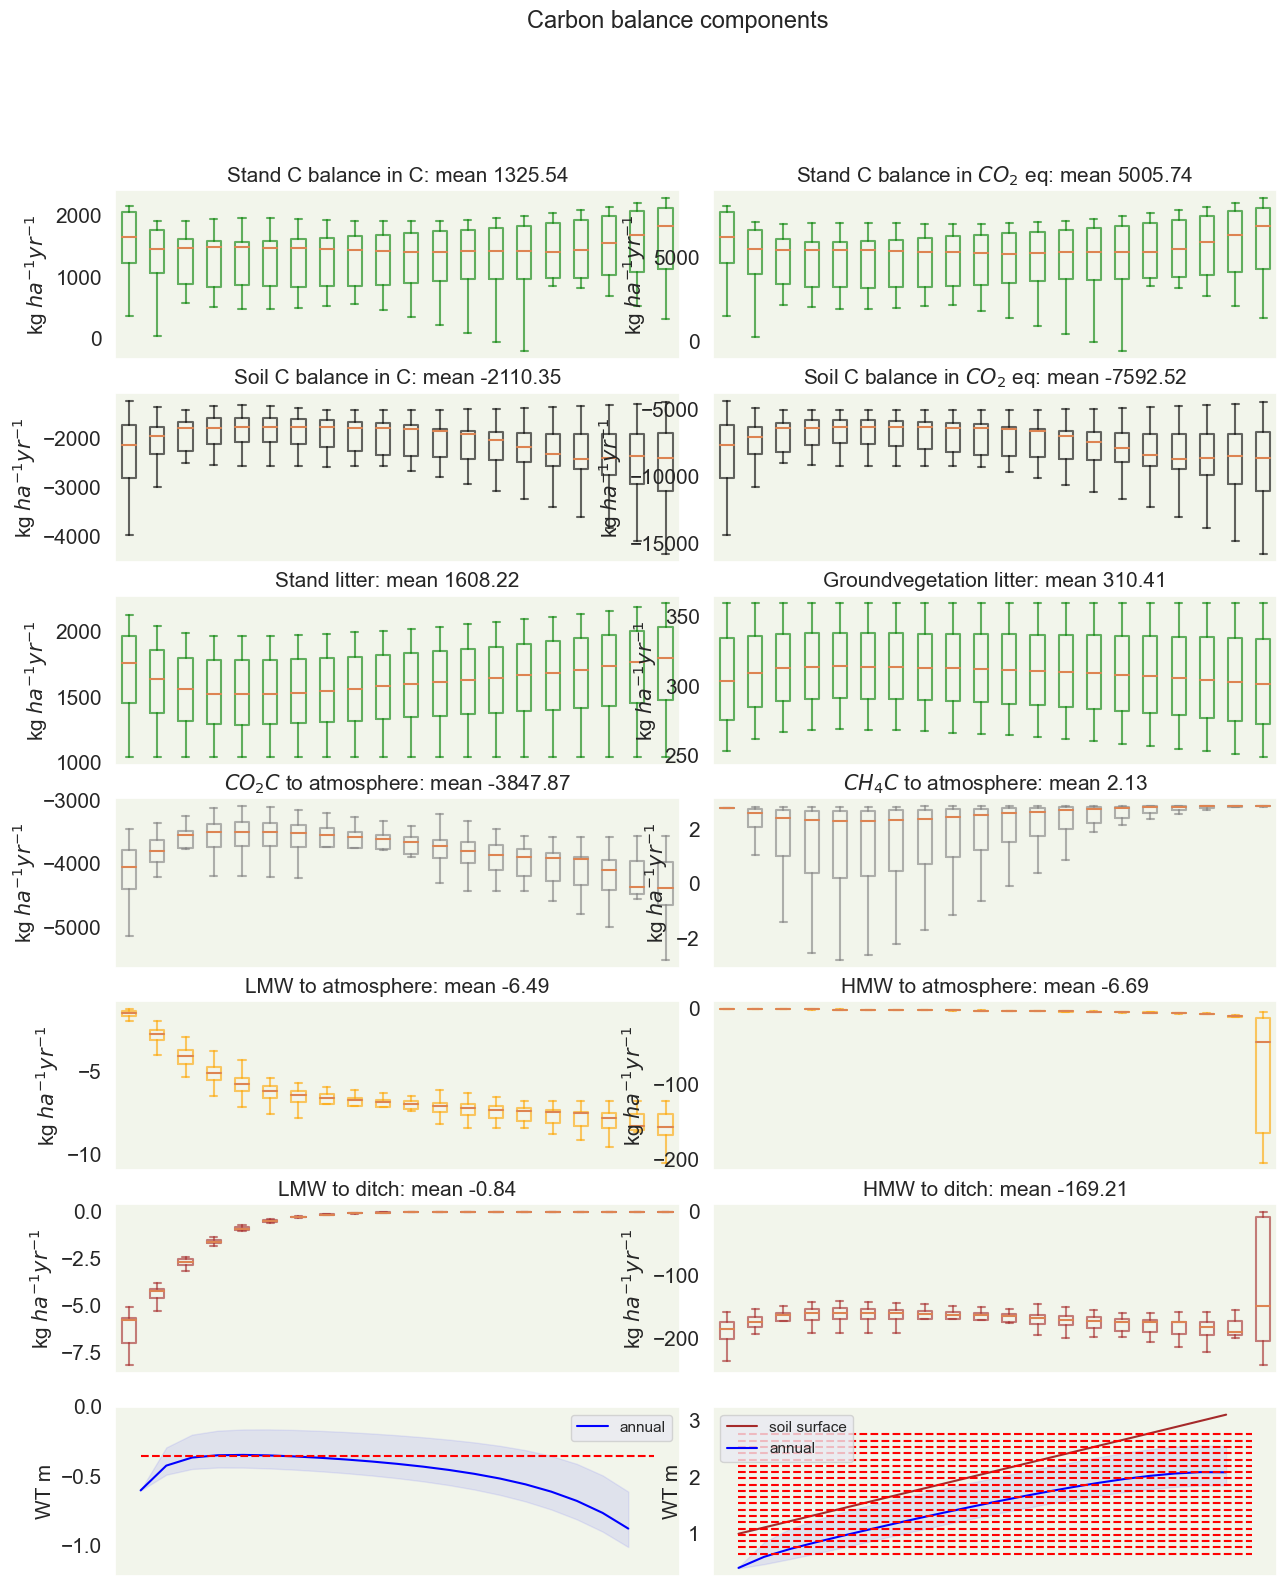

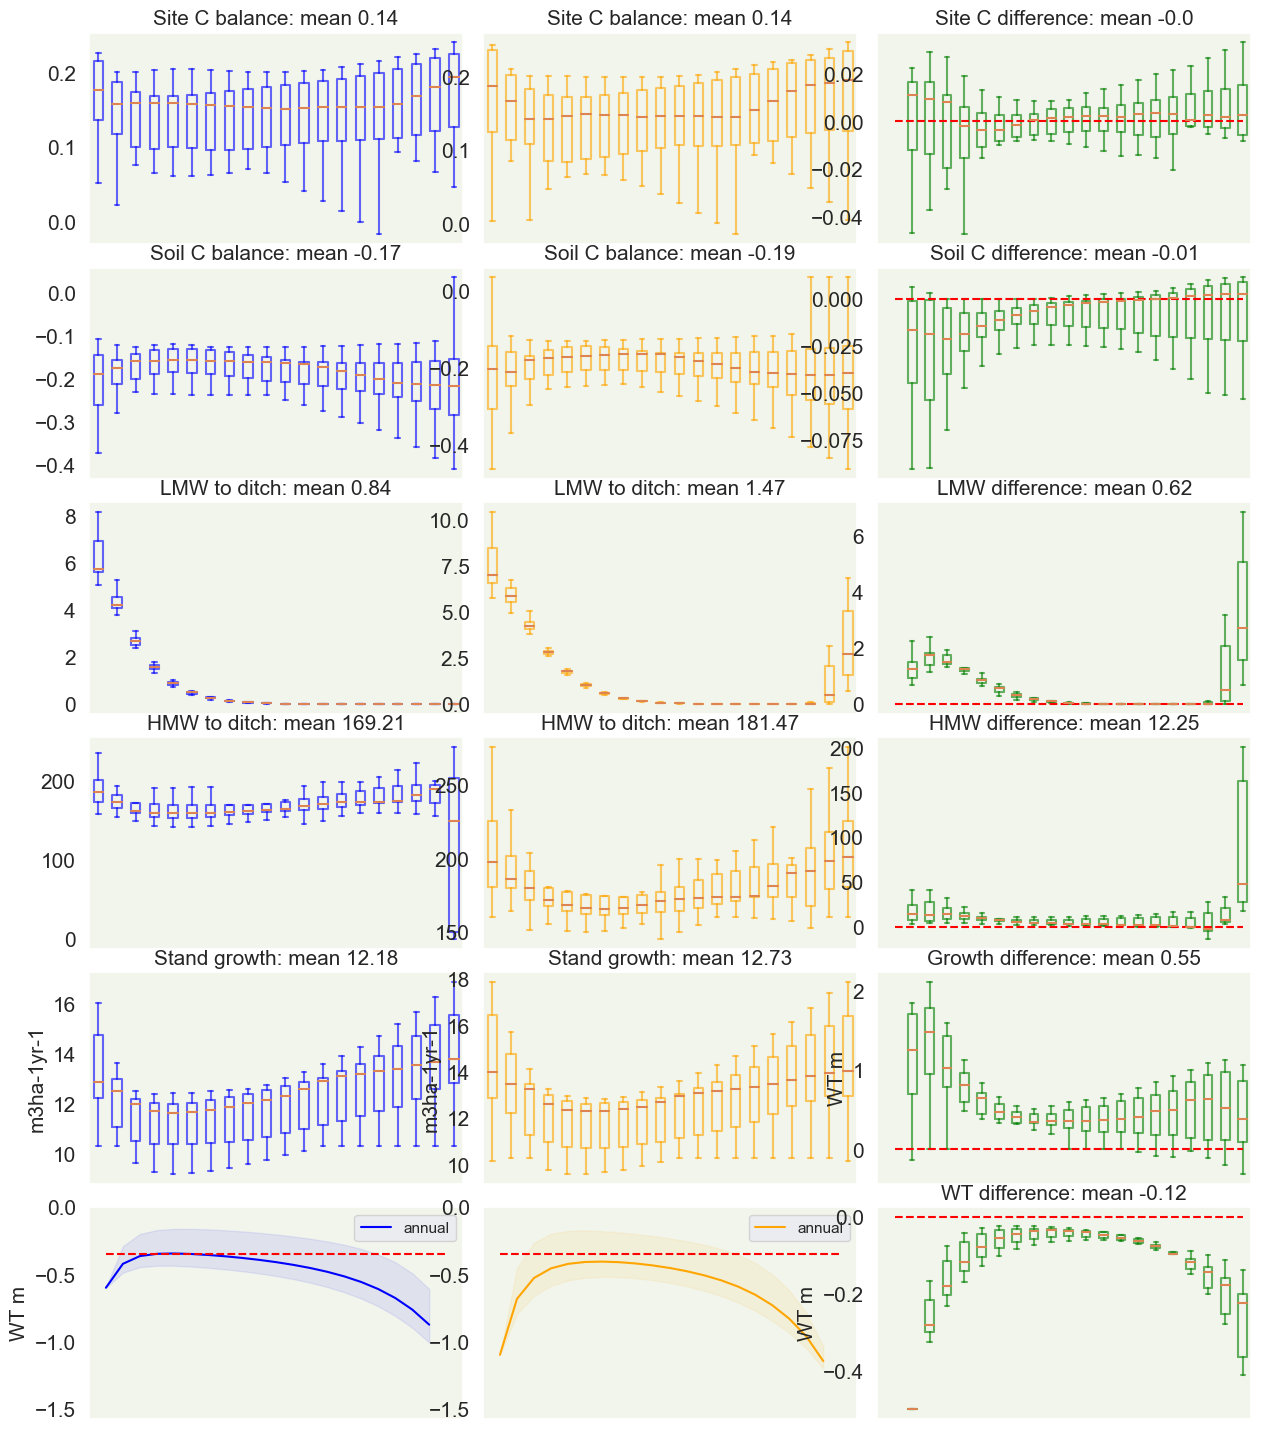

In [10]:
from susi.figures import *
from netCDF4 import Dataset 

#ff = r'susi_2022/outputs/susi.nc'
ff=outpara['outfolder']+ outpara['netcdf']  # AG added
#ff=r'outputs/swe_site_05_StraRed_susi.nc'
scen = 0

hydrology(ff, scen)
stand(ff, scen)
mass(ff, scen)
carbon(ff, scen)
compare_1(ff, [0,1])


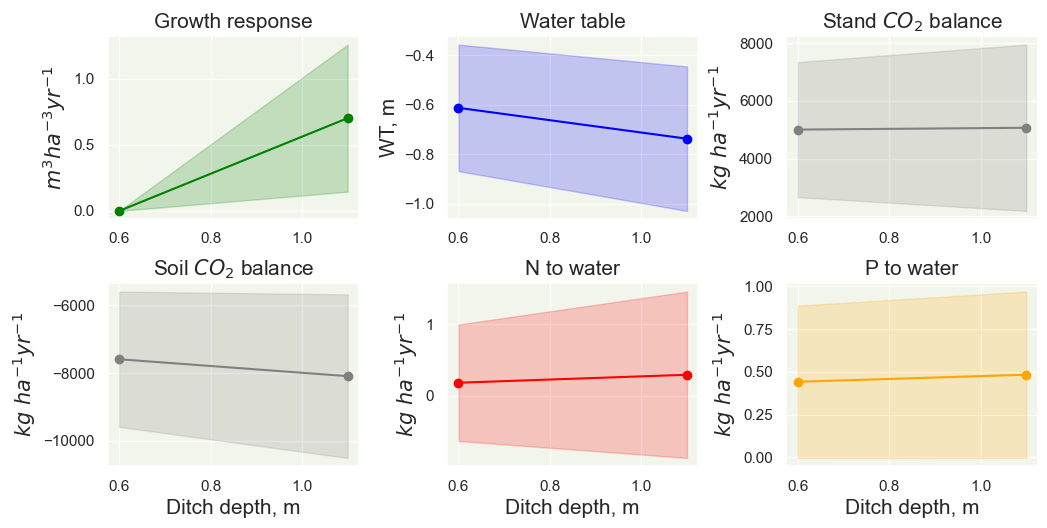

In [11]:
import dataframe_image
compare_scens(ff)

In [ ]:
# v_ini, v, iv5,  cbt, dcbt, cb, dcb, w,dw,logs,pulp, dv,dlogs,dpulp,yrs, bmgr,  \
#                                     Nleach, Pleach, Kleach, DOCleach, runoff, nrelease, \
#                                     prelease, krelease, ch4release = run_susi(forc, wpara, cpara, 
#                                     org_para, spara, outpara, photopara, start_yr, end_yr, wlocation = 'undefined', 
#                                     mottifile=mottifile, peat= 'other', photosite='All data', 
#                                     folderName=folderName,ageSim=ageSim, sarkaSim=sarkaSim, sfc=sfc, susiPath=susiPath)

# Verification

In [12]:
ncf = Dataset(ff, mode='r')

In [13]:
print(ncf)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Peatland simulator Susi results
    history: created 2023-01-24 13:20:02
    source: Susi v.2022,
    dimensions(sizes): nscens(2), ncols(20), nyrs(12), ndays(4018), nLyrs(30)
    variables(dimensions): float64 time(ndays)
    groups: scen, stand, groundvegetation, esom, fertilization, balance, cpy, strip, temperature, methane, export


In [14]:
ncf['strip']['dwt'][scen,:, :]

masked_array(
  data=[[-0.6       , -0.23940781, -0.20319553, ..., -0.22934568,
         -0.28247157, -0.6       ],
        [-0.6       , -0.263341  , -0.20839168, ..., -0.25764763,
         -0.33432004, -0.6       ],
        [-0.6       , -0.2799232 , -0.21383052, ..., -0.28317848,
         -0.36985594, -0.6       ],
        ...,
        [-0.6       , -0.46132308, -0.38693118, ..., -0.7740457 ,
         -0.8682657 , -0.97884136],
        [-0.6       , -0.4562345 , -0.38153246, ..., -0.7693185 ,
         -0.86373323, -0.9743089 ],
        [-0.6       , -0.45909598, -0.3844804 , ..., -0.770998  ,
         -0.8653037 , -0.9758794 ]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [15]:
sNames[siteID]

'07_Rothult'

In [16]:
# Uld data
# for verification
# Water table for selected station

wsite  = sNames[siteID]

obs_GWL = pd.read_csv(f'O:/projects/forestProductivity/01_data_acquisition/Ulf/SecondData/GVN_Man_ALL tidy by Alejandro Gandara.csv',
encoding='latin1', sep=';')
obs_GWL = obs_GWL.loc[(obs_GWL.Transekt == 'mean') & (obs_GWL.site == wsite)][['site','date', 'wt']]
obs_GWL.set_index('date', drop=False, inplace=True)
obs_GWL_t = obs_GWL.reindex(pd.date_range(start_date, end_date).format("YYY%-mm%-dd%"), fill_value=None).iloc[1:]
obs_GWL = obs_GWL_t.combine_first(obs_GWL)
obs_GWL.date = obs_GWL.index
obs_GWL = obs_GWL[obs_GWL.date.notnull()]
# print(len(obs_GWL))
#obs_GWL[pd.notnull(obs_GWL['wt'])]


In [17]:
ncf['stand']['basalarea'][scen,:, :]

masked_array(
  data=[[10.892124 , 10.892124 , 10.892124 , 10.892124 , 10.892124 ,
         10.892124 , 10.892124 , 10.892124 , 10.892124 , 10.892124 ,
         10.892124 , 10.892124 , 10.892124 , 10.892124 , 10.892124 ,
         10.892124 , 10.892124 , 10.892124 , 10.892124 , 10.892124 ],
        [12.249524 , 12.249523 , 12.2493305, 12.249159 , 12.249172 ,
         12.249278 , 12.249378 , 12.249486 , 12.249519 , 12.249524 ,
         12.249524 , 12.249524 , 12.249524 , 12.249524 , 12.249524 ,
         12.249524 , 12.249524 , 12.249523 , 12.24949  , 12.249121 ],
        [13.379841 , 13.271823 , 13.181772 , 13.147635 , 13.138128 ,
         13.140962 , 13.150018 , 13.163227 , 13.177688 , 13.194394 ,
         13.211627 , 13.228504 , 13.2460985, 13.262087 , 13.281762 ,
         13.3064165, 13.331999 , 13.35579  , 13.390575 , 13.414861 ],
        [14.568419 , 14.280961 , 14.114195 , 14.055851 , 14.040114 ,
         14.0449505, 14.060509 , 14.083225 , 14.109152 , 14.140049 ,
         14.17333

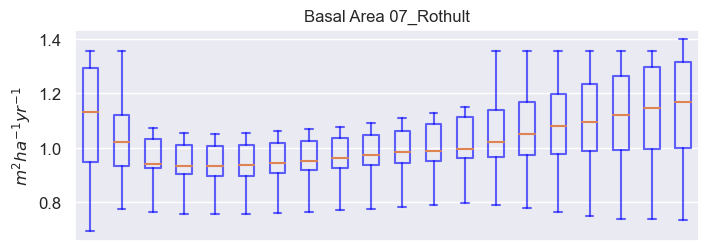

In [18]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt

facecolor = '#f2f5eb'
fs = 12
cols =ncf.dimensions['ncols'].size #20
fig = plt.figure(num='stand', figsize=(25,18))   #width, height
gs = gridspec.GridSpec(ncols=12, nrows=12, figure=fig, wspace=0.25, hspace=0.25)

ba = ncf['stand']['basalarea'][scen,:, :]
growth = np.diff(ba, axis=0)
dfgrowth = pd.DataFrame(data=growth, columns=list(range(cols)))
axgrowth = fig.add_subplot(gs[8:10, :4])
dfgrowth.boxplot(ax = axgrowth,
                color=dict(boxes='blue', whiskers='blue', medians='blue', caps='blue'),
                boxprops=dict(linestyle='-', linewidth=1.5, color='blue', alpha=0.6),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5, color='blue', alpha=0.6),
                capprops=dict(linestyle='-', linewidth=1.5, color='blue', alpha=0.6),
                showfliers=False, grid=True, rot=2)

axgrowth.set_title('Basal Area ' + wsite)
axgrowth.set_ylabel('$m^2 ha^{-1} yr^{-1}$', fontsize=fs)

axgrowth.get_xaxis().set_visible(False)
axgrowth.tick_params(axis='y', labelsize=fs)
#axgrowth.set_facecolor(facecolor)
plt.savefig(outpara['outfolder'] + '/graphs/' + site + '_Basal Area.png', bbox_inches='tight')

In [ ]:
ncf

In [19]:
# basal area
ba_mean = np.mean(ncf['stand']['basalarea'][scen,:, :], axis=1)
bai = np.diff(ba_mean, axis=0)

BasalArea = pd.DataFrame({
    'year': pd.date_range(start_date, end_date, freq="Y").strftime('%Y'),
    'ba':list(ba_mean)[1:],
    'bai':list(bai)
})
BasalArea.to_csv(outpara['outfolder'] + '/' + site + '_Basal Area.csv')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


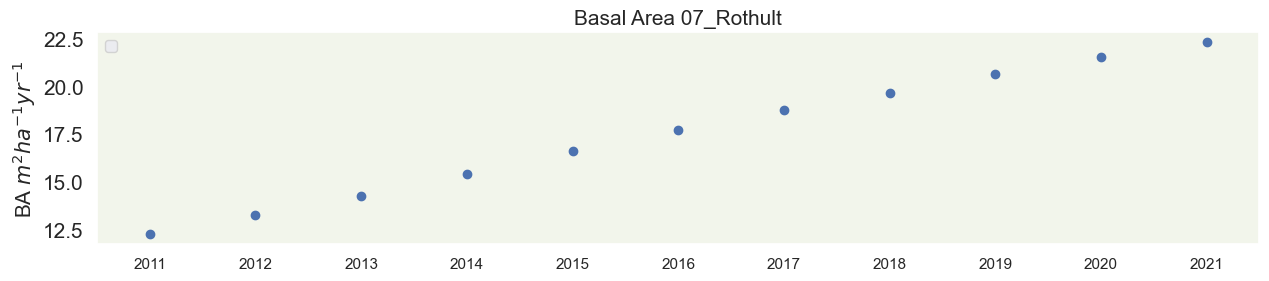

In [20]:
fs = 15
baFig = plt.figure(num='BasalArea', figsize=(15,18))
gs = gridspec.GridSpec(ncols=12, nrows=12, figure=fig, wspace=0.25, hspace=0.25)

axwtts = baFig.add_subplot(gs[8:10, :])
axwtts.scatter(x= BasalArea['year'], y=BasalArea['ba'])
axwtts.set_title('Basal Area ' + wsite, fontsize = 15)
axwtts.tick_params(axis='y', labelsize=fs)
axwtts.set_ylabel('BA $m^2 ha^{-1} yr^{-1}$', fontsize=fs)
axwtts.legend(loc= 'upper left')
axwtts.grid(visible=False)
axwtts.set_facecolor(facecolor)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


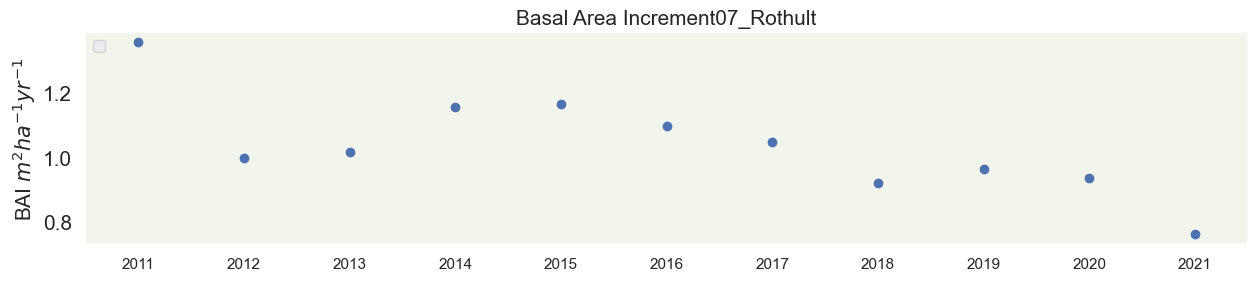

In [21]:
fs = 15
baFig = plt.figure(num='BasalArea', figsize=(15,18))
gs = gridspec.GridSpec(ncols=12, nrows=12, figure=fig, wspace=0.25, hspace=0.25)

axwtts = baFig.add_subplot(gs[8:10, :])
axwtts.scatter(x= BasalArea['year'], y=BasalArea['bai'])
axwtts.set_title('Basal Area Increment' + wsite, fontsize = 15)
axwtts.tick_params(axis='y', labelsize=fs)
axwtts.set_ylabel('BAI $m^2 ha^{-1} yr^{-1}$', fontsize=fs)
axwtts.legend(loc= 'upper left')
axwtts.grid(visible=False)
axwtts.set_facecolor(facecolor)

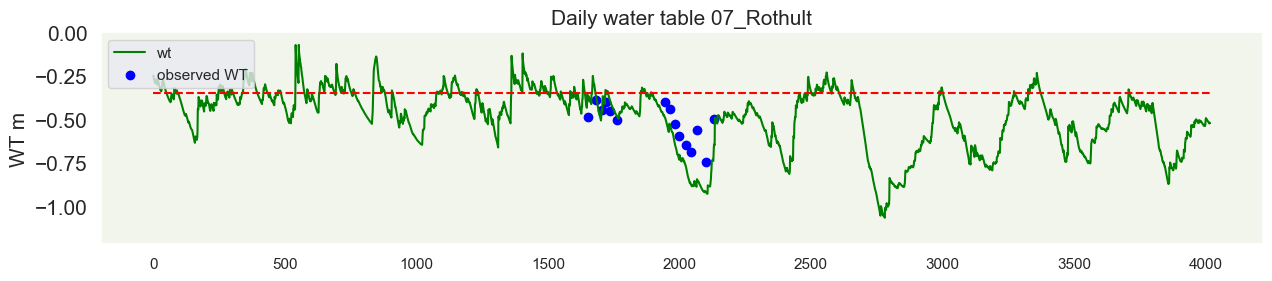

In [22]:
facecolor = '#f2f5eb'
fs = 15
fig = plt.figure(num='hydro', figsize=(15,18))   #width, height
gs = gridspec.GridSpec(ncols=12, nrows=12, figure=fig, wspace=0.25, hspace=0.25)

wt = np.mean(ncf['strip']['dwtyr'][scen,:, :], axis = 0)
cols = np.shape(wt)[0]
#wtgs = np.mean(ncf['strip']['dwtyr_growingseason'][scen,:, :], axis = 0)
#sdgs = np.std(ncf['strip']['dwtyr_growingseason'][scen,:, :], axis = 0)
wtls = np.mean(ncf['strip']['dwtyr_latesummer'][scen,:, :], axis = 0)
#sdls = np.std(ncf['strip']['dwtyr_latesummer'][scen,:, :], axis = 0)
wtmin = min(wtls) -0.2



#----------Water tables time series
wt = np.mean(ncf['strip']['dwt'][scen,:, :], axis = 1)
days = np.shape(wt)[0]
sd = np.std(ncf['strip']['dwt'][scen,:, :], axis = 1)# sdls = np.std(ncf['strip']['dwtyr_latesummer'][scen,:, :], axis = 0)

axwtts = fig.add_subplot(gs[8:10, :])
axwtts.plot(wt, color='green', label = 'wt')
axwtts.scatter(range(days), obs_GWL['wt'], color='blue', label = 'observed WT')


axwtts.hlines(y= -0.35, xmin=0, xmax = days, color='red',linestyles='--')
# for c in range(1,cols-1):
#     axwtts.plot(range(days), ncf['strip']['dwt'][scen,:, c], alpha=0.2)
    
#axwtts.get_xaxis().set_visible(False) 
axwtts.set_title('Daily water table ' + wsite, fontsize = 15)
axwtts.tick_params(axis='y', labelsize=fs)
axwtts.set_ylim([wtmin,0])
axwtts.set_ylabel('WT m', fontsize=fs)
axwtts.legend(loc= 'upper left')
axwtts.grid(visible=False)
axwtts.set_facecolor(facecolor)

plt.savefig(outpara['outfolder'] + '/graphs/' + site + '_wt.png', bbox_inches='tight')



In [ ]:
ncf.close()